# Fraud Detection CRISP DM

## Load Libraries and Data

In [16]:
import pandas as pd
import os.path
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Suppress warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
if os.path.isfile('./transaction.csv'):
    data = pd.read_json("./transactions.txt", orient='records', lines=True)
    data.to_csv('transaction.csv', sep='|', index=False)

data = pd.read_csv('transaction.csv', sep='|')


## Data Description

In [3]:
data

accountNumber  customerId  creditLimit  availableMoney  \
0           733493772   733493772         5000         5000.00   
1           733493772   733493772         5000         4888.67   
2           733493772   733493772         5000         4863.92   
3           733493772   733493772         5000         4676.52   
4           733493772   733493772         5000         4449.18   
...               ...         ...          ...             ...   
641909      186770399   186770399         7500         2574.02   
641910      186770399   186770399         7500         2568.65   
641911      186770399   186770399         7500         2344.95   
641912      186770399   186770399         7500         2206.53   
641913      186770399   186770399         7500         2190.22   

        transactionDateTime  transactionAmount              merchantName  \
0       2016-01-08T19:04:50             111.33                      Lyft   
1       2016-01-09T22:32:39              24.75                      Uber   
2       2016-01-11T13:36:55             187.40                      Lyft   
3       2016-01-11T22:47:46             227.34                      Lyft   
4       2016-01-16T01:41:11               0.00                      Lyft   
...                     ...                ...                       ...   
641909  2016-12-04T12:29:21               5.37              Apple iTunes   
641910  2016-12-09T04:20:35             223.70      Blue Mountain eCards   
641911  2016-12-16T07:58:23             138.42             Fresh Flowers   
641912  2016-12-19T02:30:35              16.31                   abc.com   
641913  2016-12-28T11:14:14              32.53  Next Day Online Services   

       acqCountry merchantCountryCode  posEntryMode  posConditionCode  \
0              US                  US           5.0               1.0   
1              US                  US           9.0               1.0   
2              US                  US           5.0               1.0   
3              US                  US           2.0               1.0   
4              US                  US           2.0               1.0   
...           ...                 ...           ...               ...   
641909         US                  US           5.0               8.0   
641910         US                  US           9.0               1.0   
641911         US                  US           2.0               1.0   
641912         US                  US           9.0               8.0   
641913         US                  US           9.0               1.0   

        merchantCategoryCode currentExpDate accountOpenDate  \
0                  rideshare        04/2020      2014-08-03   
1                  rideshare        06/2023      2014-08-03   
2                  rideshare        12/2027      2014-08-03   
3                  rideshare        09/2029      2014-08-03   
4                  rideshare        10/2024      2014-08-03   
...                      ...            ...             ...   
641909            mobileapps        01/2030      2015-11-04   
641910          online_gifts        05/2026      2015-11-04   
641911          online_gifts        10/2019      2015-11-04   
641912  online_subscriptions        11/2029      2015-11-04   
641913          online_gifts        08/2025      2015-11-04   

       dateOfLastAddressChange  cardCVV  enteredCVV  cardLast4Digits  \
0                   2014-08-03      492         492             9184   
1                   2014-08-03      492         492             9184   
2                   2014-08-03      492         492             9184   
3                   2014-08-03      492         492             9184   
4                   2014-08-03      492         492             9184   
...                        ...      ...         ...              ...   
641909              2016-06-03      127         127             5432   
641910              2016-06-03      127         127             5432   
641911              

In [4]:
print("Column names:")
print('; '.join(data.columns.values))

Column names:
accountNumber; customerId; creditLimit; availableMoney; transactionDateTime; transactionAmount; merchantName; acqCountry; merchantCountryCode; posEntryMode; posConditionCode; merchantCategoryCode; currentExpDate; accountOpenDate; dateOfLastAddressChange; cardCVV; enteredCVV; cardLast4Digits; transactionType; isFraud; echoBuffer; currentBalance; merchantCity; merchantState; merchantZip; cardPresent; posOnPremises; recurringAuthInd; expirationDateKeyInMatch


In [5]:
print("Dataset duration: " + str(min(data['transactionDateTime'])) + " - " + str(max(data['transactionDateTime'])))
print("User Number: " + str(data['customerId'].nunique()))
print("Transaction: " + str(data.shape[0]))
print("Median Transaction per User: " + str(data.groupby('customerId')['customerId'].agg('count').median()))
print()

Dataset duration: 2016-01-01T00:00:37 - 2016-12-30T23:59:27
User Number: 5000
Transaction: 641914
Median Transaction per User: 47.0



In [6]:
print("missing data")
data.isnull().sum()

missing data


accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    3913
merchantCountryCode            624
posEntryMode                  3345
posConditionCode               287
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                589
isFraud                          0
echoBuffer                  641914
currentBalance                   0
merchantCity                641914
merchantState               641914
merchantZip                 641914
cardPresent                      0
posOnPremises               641914
recurringAuthInd            641914
expirationDateKeyInM

In [7]:
# Convert date data to datetime
data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'], format="%Y-%m-%dT%H:%M:%S")
data['currentExpDate'] = pd.to_datetime(data['currentExpDate'], format="%m/%Y")
data['accountOpenDate'] = pd.to_datetime(data['accountOpenDate'], format="%Y-%m-%d")
data['dateOfLastAddressChange'] = pd.to_datetime(data['dateOfLastAddressChange'], format="%Y-%m-%d")


## EDA

### Numerical Data Summaries

In [8]:
# drop missing data columns
column_dropped = ['merchantCity', 'merchantState', 'merchantZip', 'echoBuffer', 'posOnPremises', 'recurringAuthInd']
data.drop(columns=column_dropped).describe().T

count          mean           std           min  \
accountNumber      641914.0  5.547701e+08  2.546884e+08  1.005471e+08   
customerId         641914.0  5.547701e+08  2.546884e+08  1.005471e+08   
creditLimit        641914.0  1.069721e+04  1.146036e+04  2.500000e+02   
availableMoney     641914.0  6.652829e+03  9.227132e+03 -1.244930e+03   
transactionAmount  641914.0  1.351625e+02  1.470533e+02  0.000000e+00   
posEntryMode       638569.0  9.136460e+00  1.696118e+01  2.000000e+00   
posConditionCode   641627.0  3.238367e+00  9.680862e+00  1.000000e+00   
cardCVV            641914.0  5.571999e+02  2.573262e+02  1.000000e+02   
enteredCVV         641914.0  5.567752e+02  2.574026e+02  1.000000e+00   
cardLast4Digits    641914.0  4.886184e+03  2.859054e+03  0.000000e+00   
currentBalance     641914.0  4.044382e+03  5.945510e+03  0.000000e+00   

                            25%           50%           75%           max  
accountNumber      3.223192e+08  5.438879e+08  7.862277e+08  9.999853e+08  
customerId         3.223192e+08  5.438879e+08  7.862277e+08  9.999853e+08  
creditLimit        5.000000e+03  7.500000e+03  1.500000e+04  5.000000e+04  
availableMoney     1.114970e+03  3.578165e+03  8.169185e+03  5.000000e+04  
transactionAmount  3.232000e+01  8.580000e+01  1.890300e+02  1.825250e+03  
posEntryMode       2.000000e+00  5.000000e+00  9.000000e+00  9.000000e+01  
posConditionCode   1.000000e+00  1.000000e+00  1.000000e+00  9.900000e+01  
cardCVV            3.340000e+02  5.810000e+02  7.620000e+02  9.980000e+02  
enteredCVV         3.330000e+02  5.800000e+02  7.610000e+02  9.980000e+02  
cardLast4Digits    2.364000e+03  4.873000e+03  7.267000e+03  9.998000e+03  
currentBalance     5.024425e+02  2.151860e+03  5.005890e+03  4.749650e+04

### Histogram

In [25]:
# select column included in hsitogram
eda_df = data.drop(columns=column_dropped + ['isFraud'])

# print all histogram
n_col = 1
n_row = eda_df.shape[1] // n_col + (eda_df.shape[1] % n_col > 0)

fig, ax = plt.subplots(nrows=n_row, ncols=n_col, figsize=[20, 3 * n_row])

ax = ax.flatten()

colors = ['#f44336', '#009688']
labels = ['Fraud', 'not Fraud']

axi = 0
for label, content in eda_df.items():
    # print(label)

    if content.dtype == 'bool':
        content = content + 0

    # stack by isFraud
    content_isFraud = [content.loc[data['isFraud'] == n].dropna() for n in [True, False]]

    # show as categorial for unique less than 4
    if content.dtype == 'object':
        ax[axi].hist(content_isFraud, bins=content.nunique(), density=True,
                     histtype='bar', color=colors, label=labels)
        ax[axi].set_xticks(content.dropna().unique())
#         if content.nunique() > 5:
#             ax[axi].set_xticklabels(labels=content.unique(), rotation='vertical')
    else:
        # show histogram
        ax[axi].hist(content_isFraud, bins=30, density=True,
                     histtype='bar', color=colors, label=labels)

    # add legend
    ax[axi].legend(prop={'size': 10})

    # add title
    ax[axi].set_title(label)

    axi += 1


plt.tight_layout()

In [26]:
fig.savefig('original_histogram.png')

In [10]:
data.loc[data['isFraud'], :]

accountNumber  customerId  creditLimit  availableMoney  \
0           733493772   733493772         5000         5000.00   
3           733493772   733493772         5000         4676.52   
73          733493772   733493772         5000         2730.06   
80          733493772   733493772         5000         2394.36   
85          733493772   733493772         5000          910.91   
...               ...         ...          ...             ...   
641627      877651598   877651598         7500         5802.15   
641792      455115932   455115932        50000        34545.80   
641812      455115932   455115932        50000        33255.25   
641870      186770399   186770399         7500         6448.10   
641874      186770399   186770399         7500         5756.53   

       transactionDateTime  transactionAmount                   merchantName  \
0      2016-01-08 19:04:50             111.33                           Lyft   
3      2016-01-11 22:47:46             227.34                           Lyft   
73     2016-06-07 22:40:50              78.92                           Lyft   
80     2016-06-16 06:43:35             665.84                           Lyft   
85     2016-06-26 06:14:02             665.84                           Lyft   
...                    ...                ...                            ...   
641627 2016-11-26 09:23:07              44.27                     target.com   
641792 2016-09-12 00:18:28              12.71  Blue Mountain Online Services   
641812 2016-10-17 04:27:42             695.87                  Fresh Flowers   
641870 2016-05-19 08:55:28              92.60  Blue Mountain Online Services   
641874 2016-06-06 05:02:15             164.48  Blue Mountain Online Services   

       acqCountry merchantCountryCode  posEntryMode  posConditionCode  \
0              US                  US           5.0               1.0   
3              US                  US           2.0               1.0   
73             US                  US           5.0               1.0   
80             US                  US           2.0               1.0   
85             US                  US           2.0               1.0   
...           ...                 ...           ...               ...   
641627         US                  US           5.0               1.0   
641792         US                  US           5.0               1.0   
641812         US                  US           9.0               1.0   
641870         US                  US           2.0               1.0   
641874         US                  US           2.0               1.0   

       merchantCategoryCode currentExpDate accountOpenDate  \
0                 rideshare     2020-04-01      2014-08-03   
3                 rideshare     2029-09-01      2014-08-03   
73                rideshare     2027-09-01      2014-08-03   
80                rideshare     2031-08-01      2014-08-03   
85                rideshare     2031-08-01      2014-08-03   
...                     ...            ...             ...   
641627        online_retail     2019-02-01      2012-01-07   
641792         online_gifts     2023-04-01      2011-02-02   
641812         online_gifts     2024-08-01      2011-02-02   
641870         online_gifts     2026-06-01      2015-11-04   
641874         online_gifts     2031-10-01      2015-11-04   

       dateOfLastAddressChange  cardCVV  enteredCVV  cardLast4Digits  \
0                   2014-08-03      492         492             9184   
3                   2014-08-03      492         492             9184   
73                  2014-08-03      492         492             9184   
80                  2014-08-03      492         492             9184   
85                  2014-08-03      492         492             9184   
...                        ...      ...         ...              ...   
641627              2012-01-07      547         547             3593   
641792              2011-02-02      148         148     

### Feature Engineering

In [19]:
# plotting helper


def feature_plotter(feature, label, size=[15, 10], categorical=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)

    if feature.dtype == 'bool':
        content = feature + 0
    else:
        content = feature

    colors = ['#f44336', '#009688']
    labels = ['Fraud', 'not Fraud']

    # stack by isFraud
    content_isFraud = [content.loc[label == n].dropna() for n in [True, False]]

    # categorical or not
    if categorical:
        ax.hist(content_isFraud, bins=content.nunique(), density=True,
                histtype='bar', color=colors, label=labels)
        ax.set_xticks(content.dropna().unique())
    else:
        # show histogram
        ax.hist(content_isFraud, bins=30, density=True,
                histtype='bar', color=colors, label=labels)

    # add legend
    ax.legend(prop={'size': 10})

    # add title
    ax.set_title(feature.name)

    plt.tight_layout()


#### Fraud Rate by Customer Distribution

In [41]:
# is Fraud distribution by customer Id
fraud_by_customer_Id = data.groupby('customerId')['isFraud'].agg(lambda x: x.sum() / x.count())

fraud_by_customer_Id.name = 'Fraud Rate by Customer Distribution'

isFraud = fraud_by_customer_Id > 0

feature_plotter(fraud_by_customer_Id, isFraud, size=[10, 5])

isFraud label is label when fraudulent transaction appears among customer. No customer have 100% fraud transaction i.e 1 fraud rate.

#### Dates features

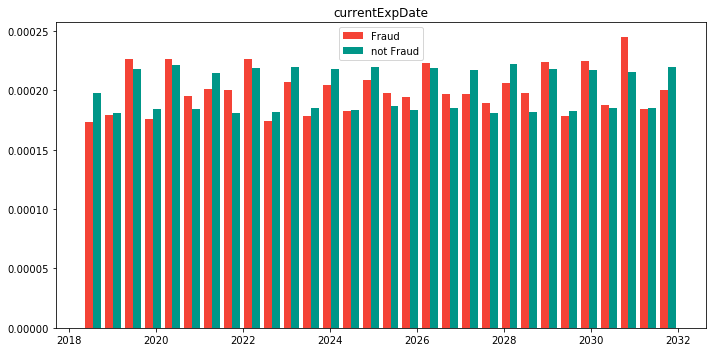

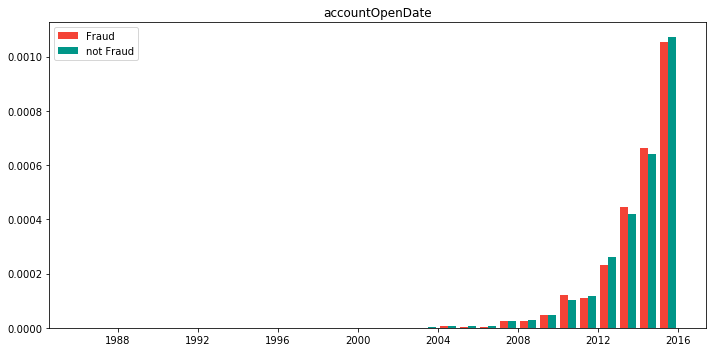

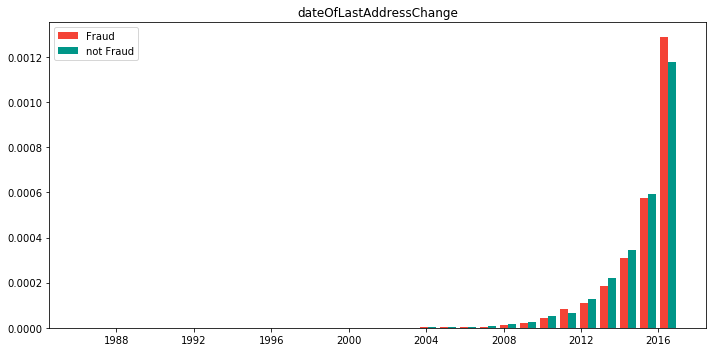

In [43]:
feature_plotter(data['transactionDateTime'], data['isFraud'], size=[10, 5])
feature_plotter(data['currentExpDate'], data['isFraud'], size=[10, 5])
feature_plotter(data['accountOpenDate'], data['isFraud'], size=[10, 5])
feature_plotter(data['dateOfLastAddressChange'], data['isFraud'], size=[10, 5])

##### Transaction Dates
We have better fraud rate in second half of 2016. But since the transaction date in the past and new sample would have greater than 2016, we try to change transaction date into months number, day of week and hour

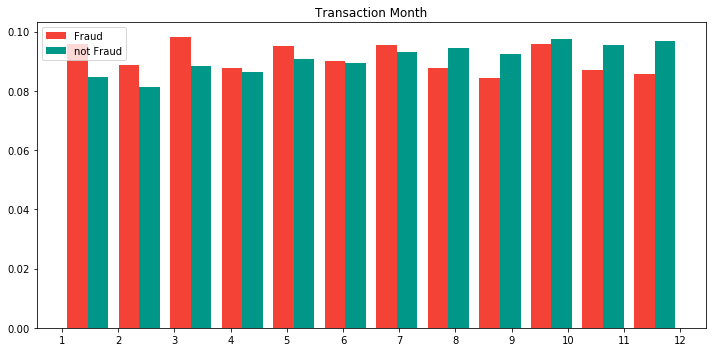

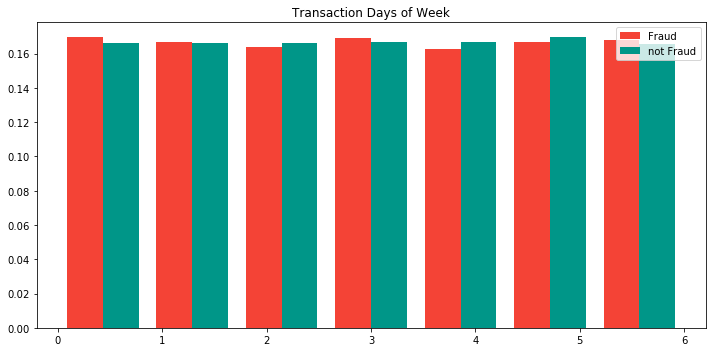

In [57]:
transaction_month = data['transactionDateTime'].dt.strftime("%m").astype('int')
transaction_month.name = "Transaction Month"
feature_plotter(transaction_month, data['isFraud'], size=[10, 5], categorical=True)

transaction_daysofweek = data['transactionDateTime'].dt.strftime("%w").astype('int')
transaction_daysofweek.name = "Transaction Days of Week"
feature_plotter(transaction_daysofweek, data['isFraud'], size=[10, 5], categorical=True)

transaction_hour = data['transactionDateTime'].dt.strftime("%H").astype('int')
transaction_hour.name = "Transaction Hours"
feature_plotter(transaction_hour, data['isFraud'], size=[10, 5], categorical=True)

##### Expiry Date / Year
Not much pattern in expiry date. But we try to plot distance of expiry date to transaction date and account open date

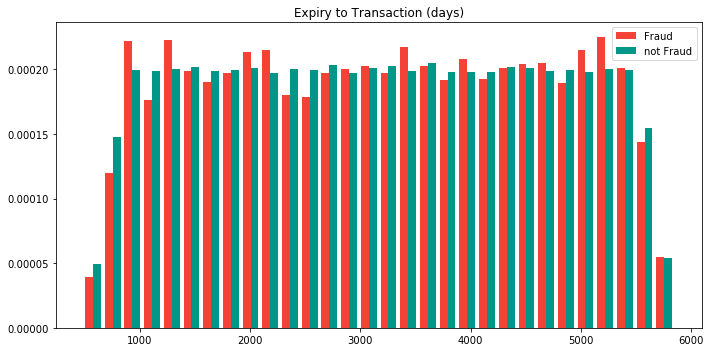

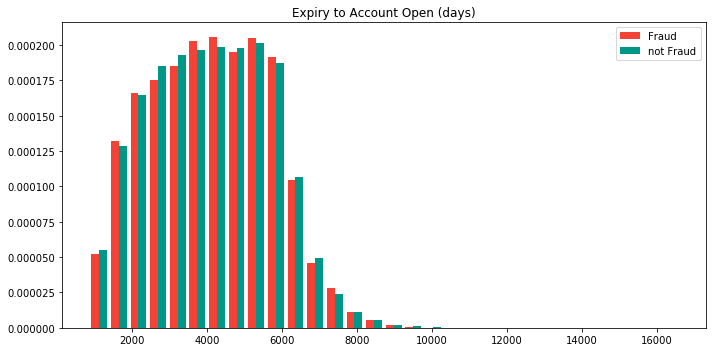

In [68]:
expiry_to_transaction = (data['currentExpDate'] - data['transactionDateTime']).dt.days
expiry_to_transaction.name = "Expiry to Transaction (days)"
feature_plotter(expiry_to_transaction, data['isFraud'], size=[10, 5])

expiry_to_open = (data['currentExpDate'] - data['accountOpenDate']).dt.days
expiry_to_open.name = "Expiry to Account Open (days)"
feature_plotter(expiry_to_open, data['isFraud'], size=[10, 5])

##### Account Open and Date Last Address Change

Older account and recently changed address seems more fraudulent. We try to plot distance of both to transaction date and each other. The shorter distance to transsaction date seems more fraudulent

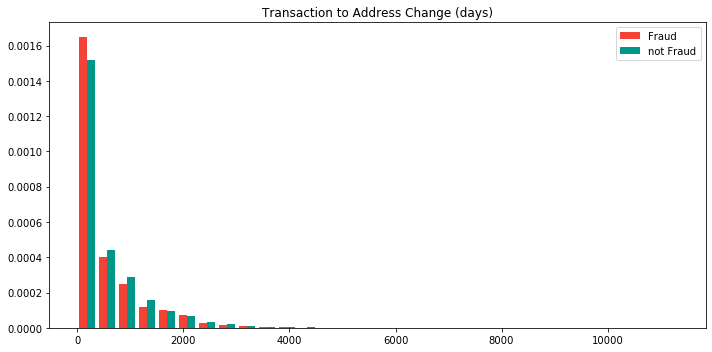

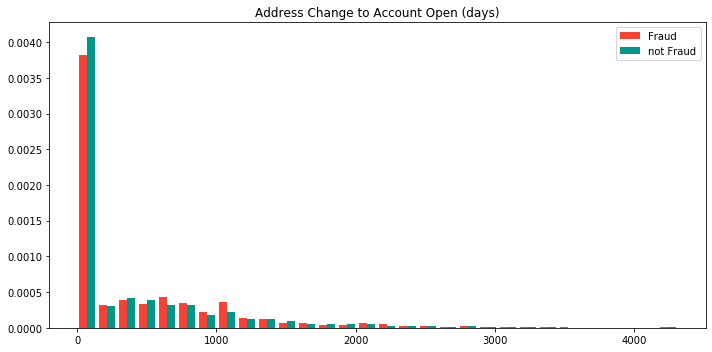

In [71]:
transaction_to_open = (data['transactionDateTime'] - data['accountOpenDate']).dt.days
transaction_to_open.name = "Transaction to Open (days)"
feature_plotter(transaction_to_open, data['isFraud'], size=[10, 5])

transaction_to_addresschange = (data['transactionDateTime'] - data['dateOfLastAddressChange']).dt.days
transaction_to_addresschange.name = "Transaction to Address Change (days)"
feature_plotter(transaction_to_addresschange, data['isFraud'], size=[10, 5])

addresschange_to_open = (data['dateOfLastAddressChange'] - data['accountOpenDate']).dt.days
addresschange_to_open.name = "Address Change to Account Open (days)"
feature_plotter(addresschange_to_open, data['isFraud'], size=[10, 5])

#### Monetary features

'creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance' for now leave it 


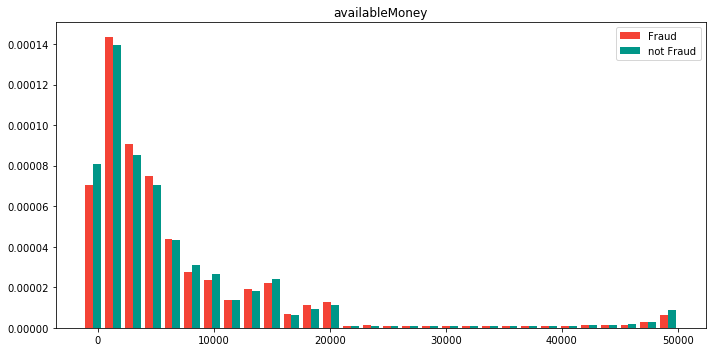

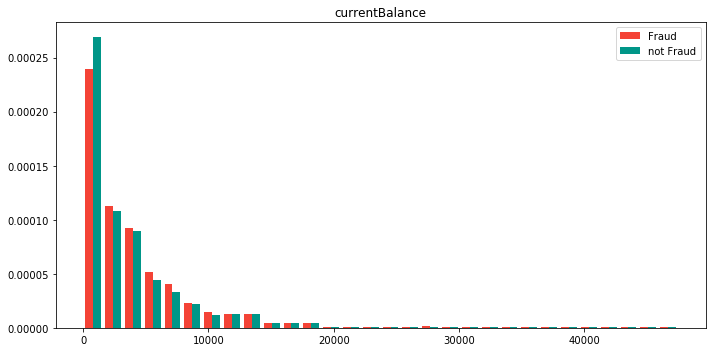

In [75]:
feature_plotter(data['creditLimit'], data['isFraud'], size=[10, 5])
feature_plotter(data['availableMoney'], data['isFraud'], size=[10, 5])
feature_plotter(data['transactionAmount'], data['isFraud'], size=[10, 5])
feature_plotter(data['currentBalance'], data['isFraud'], size=[10, 5])

#### Card Feature

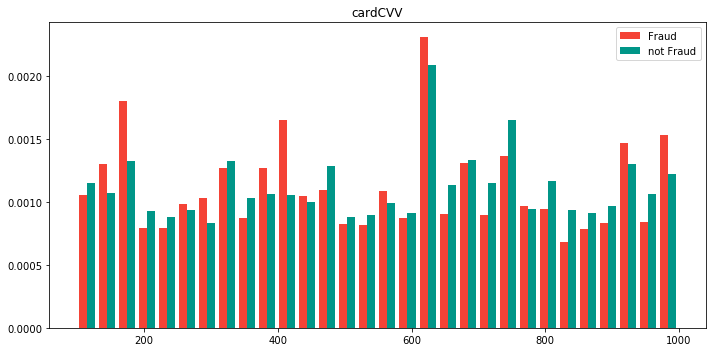

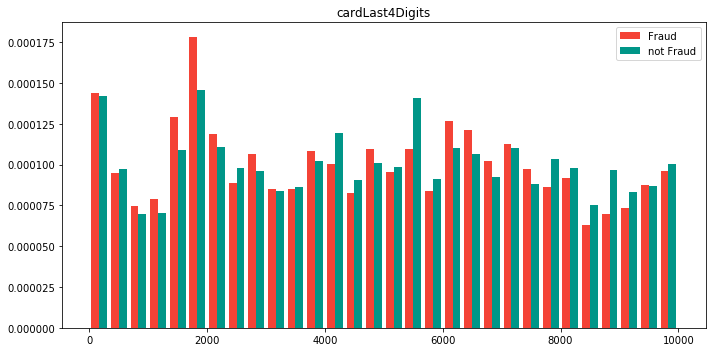

In [80]:
feature_plotter(data['cardCVV'], data['isFraud'], size=[10, 5])
feature_plotter(data['enteredCVV'], data['isFraud'], size=[10, 5])
feature_plotter(data['cardLast4Digits'], data['isFraud'], size=[10, 5])
feature_plotter(data['cardPresent'], data['isFraud'], size=[10, 5], categorical=True)


##### CVV Match

In [82]:
cvv_match = data['cardCVV'] == data['enteredCVV']
cvv_match.name = "CVV Matched"
feature_plotter(cvv_match, data['isFraud'], size=[10, 5], categorical=True)

#### Country Feature

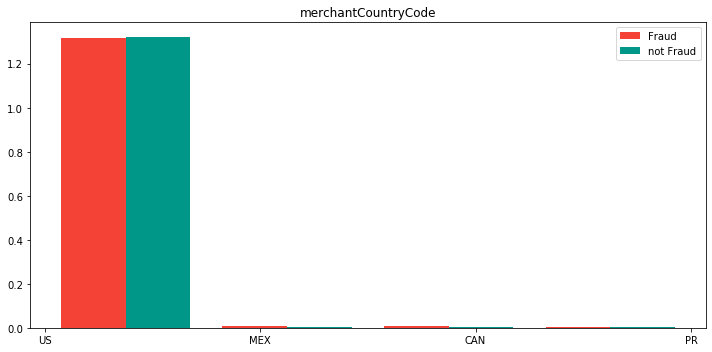

In [83]:
feature_plotter(data['acqCountry'], data['isFraud'], size=[10, 5], categorical=True)
feature_plotter(data['merchantCountryCode'], data['isFraud'], size=[10, 5], categorical=True)


##### Country Match

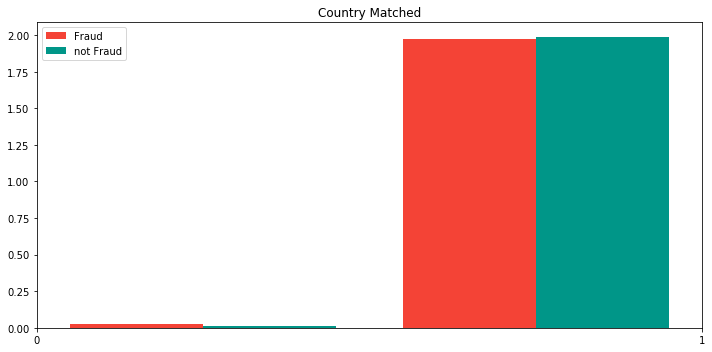

In [84]:
country_match = data['acqCountry'] == data['merchantCountryCode']
country_match.name = "Country Matched"
feature_plotter(country_match, data['isFraud'], size=[10, 5], categorical=True)

#### Transaction Type

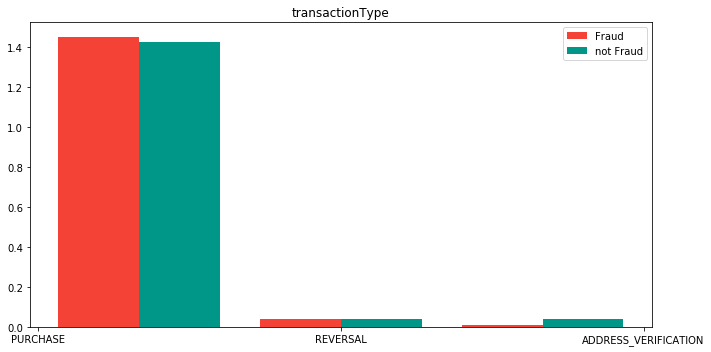

In [86]:
feature_plotter(data['transactionType'], data['isFraud'], size=[10, 5], categorical=True)

#### Pos Code feature

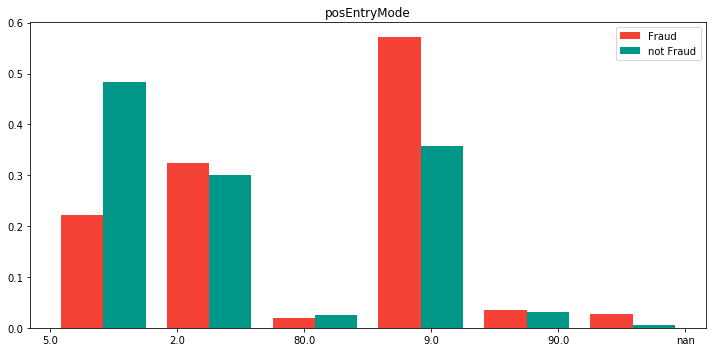

In [89]:
feature_plotter(data['posEntryMode'].astype('str'), data['isFraud'], size=[10, 5], categorical=True)
feature_plotter(data['posConditionCode'].astype('str'), data['isFraud'], size=[10, 5], categorical=True)

#### Merchant feature

In [91]:
feature_plotter(data['merchantCategoryCode'], data['isFraud'], size=[20, 10], categorical=True)

In [127]:
# Fraud Rate by merchant
data_shortMerchantName = data
data_shortMerchantName['merchantName'] = data_shortMerchantName['merchantName'].str.replace(r'#\d+', '')
fraud_by_merchantName = data_shortMerchantName.groupby(['merchantCategoryCode', 'merchantName'])['isFraud'].\
    agg({'fraudRate': lambda x: x.sum() / x.count(),
         'trancsactonNummber': lambda x: x.count()})
fraud_by_merchantName = fraud_by_merchantName.reset_index().sort_values('fraudRate', ascending=False)

In [128]:
fraud_by_merchantName.loc[fraud_by_merchantName['fraudRate'] > 0.03, :]


merchantCategoryCode              merchantName  fraudRate  \
12                  auto               Fast Repair   0.172084   
148               hotels              Hyatt House    0.101999   
118            furniture               Ethan Allen   0.054054   
64                  food                 34th BBQ    0.040661   
75                  food              Boston Diner   0.038674   
91                  food             John's Bistro   0.038411   
5                   auto  Convenient Auto Services   0.038241   
69                  food              Best Bistro    0.037868   
149               hotels           Marriott Hotels   0.036697   
0                airline         American Airlines   0.036254   
139               health                     NYSC    0.033375   
98                  food                South Cafe   0.032852   
184        personal care           Northtown Salon   0.031746   
62                  food            1st Restaurant   0.031496   
74                  food              Boston Cafe    0.030128   
46              fastfood                 In-N-Out    0.030068   

     trancsactonNummber  
12                  523  
148                3451  
118                 555  
64                 5927  
75                  724  
91                  755  
5                   523  
69                 1426  
149                 109  
0                  1986  
139                1618  
98                  761  
184                 252  
62                  762  
74                 2257  
46                 5421